# Предварительный анализ данных

In [111]:
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from clickhouse_driver import Client

%matplotlib inline

In [42]:
# Подключение к серверу
# У нас на Амазоне развернут кластер из двух серверов
client = Client('3.23.248.232', user='default', password='qwerty') # наш первый сервер
#client = Client('3.23.221.144', user='default', password='qwerty') # наш второй сервер

## Анализ набора данных с предложениями о продаже квартир

Здесь приводится обзорный анализ информации, которая была получена в результате сбора данных и выводы, которые были сделаны по поводу методов дальнейшего анализа.

In [47]:
# Загружаем информацию о предложениях из ClickHouse и сохраняем в DataFrame
offers, columns = client.execute('select * from realty_db.distr_offers', with_column_types=True)
df_offers = pd.DataFrame(offers, columns=[tuple[0] for tuple in columns])
df_offers

offer_id  complex_id  builder_id  rooms_cnt     square  floor  \
0      217168767       10185        8125          0  25.000000      4   
1      221687775       10185        8125          0  22.000000     17   
2      223170687       10185        8125          1  35.299999      2   
3      226637924       10185        8125          0  22.000000     18   
4      229920139       10185        8125          1  36.580002     12   
...          ...         ...         ...        ...        ...    ...   
77666  228521999          96        8093          2  45.299999      5   
77667  229237248          96        8093          1  42.599998      9   
77668  232036234          96        8093          3  96.800003      4   
77669  233171320          96        8093          1  49.099998      5   
77670  233612599          96        8093          1  40.400002      7   

       total_floors  total_price  price_for_meter nearest_subway  \
0                10      2000000            80000      Девяткино   
1                17      2000000            90909      Девяткино   
2                10      3100000            87819      Девяткино   
3                21      2150000            97727      Девяткино   
4                19      3200000            87479      Девяткино   
...             ...          ...              ...            ...   
77666             9      5300000           116998      Ладожская   
77667             9      3151000            73967      Ладожская   
77668             9      5933000            61291      Ладожская   
77669             9      5300000           107943      Ладожская   
77670             9      3000000            74257      Ладожская   

       minutes_to_subway  is_walk  
0                     20        0  
1                     20        0  
2                     20        0  
3                     20        0  
4                     20        0  
...                  ...      ...  
77666                 -1        0  
77667                 15        0  
77668                 19        0  
77669                 -1        0  
77670                 -1        0  

[77671 rows x 12 columns]

In [46]:
# Загружаем информацию о жилых комплексах из ClickHouse и сохраняем в DataFrame
complexes, columns = client.execute('select complex_id, complex_name from realty_db.distr_complexes_info', with_column_types=True)
df_complexes = pd.DataFrame(complexes, columns=[tuple[0] for tuple in columns])
complexes_ids = df_complexes['complex_id'].values
complexes_names = df_complexes['complex_name'].values

In [48]:
# Функция получения названия жк по id, она пригодится в дальнейшем анализе
def get_complex_name_by_id(complex_id):
    res = "No name"
    for i in range(len(complexes_ids)):
        if complexes_ids[i] == complex_id:
            res = complexes_names[i]
    return res

In [49]:
# Разделяем DataFrame со всеми предложениями на отдельные DataFrames для квартир разной комнатности
# Отдельно рассматриваются квартиры студии, одно-, двух- и трехкомнатные и квартиры с более чем тремя комнатами
studios_df = df_offers[df_offers['rooms_cnt'] == 0].reset_index(drop=True)
room1_df = df_offers[df_offers['rooms_cnt'] == 1].reset_index(drop=True)
room2_df = df_offers[df_offers['rooms_cnt'] == 2].reset_index(drop=True)
room3_df = df_offers[df_offers['rooms_cnt'] == 3].reset_index(drop=True)
big_flats_df = df_offers[df_offers['rooms_cnt'] > 3].reset_index(drop=True)

In [50]:
# Сохраняем отдельно массивы цен на квартиры каждого из описанных выше типов
prices_studios = studios_df['total_price'].values
prices_1r = room1_df['total_price'].values
prices_2r = room2_df['total_price'].values
prices_3r = room3_df['total_price'].values
prices_bigflat = big_flats_df['total_price'].values

### Общая информация о предложениях на квартиры разной комнатности 

In [57]:
# Функция для вывода текстовой статистики по квартирам разных типов, объявления о которых есть в наборе данных
def get_statistics_info_about_flats(flats_df, str_flat_type):
    prices = flats_df['total_price'].values
    prices_per_meter = flats_df['price_for_meter'].values
    
    prices_mean_val = np.mean(prices)
    prices_median_val = np.median(prices)
    
    prices_min_val = np.min(prices)
    complex_with_min_price = flats_df[flats_df.index == np.argmin(prices)]['complex_id']
    square_with_min_price = flats_df[flats_df.index == np.argmin(prices)]['square']
    price_for_meter_with_min_price = flats_df[flats_df.index == np.argmin(prices)]['price_for_meter']
        
    prices_max_val = np.max(prices)
    complex_with_max_price = flats_df[flats_df.index == np.argmax(prices)]['complex_id']
    square_with_max_price = flats_df[flats_df.index == np.argmax(prices)]['square']
    price_for_meter_with_max_price = flats_df[flats_df.index == np.argmax(prices)]['price_for_meter']
    
    price_for_meter_min = np.min(prices_per_meter)
    complex_with_min_price_for_meter = flats_df[flats_df.index == np.argmin(prices_per_meter)]['complex_id']

    price_for_meter_max = np.max(prices_per_meter)
    complex_with_max_price_for_meter = flats_df[flats_df.index == np.argmax(prices_per_meter)]['complex_id']

    print('Mean price for the ' + str_flat_type + ' in St.Petersburg:', round(prices_mean_val))
    print('Median price for the ' + str_flat_type + ' in St.Petersburg:', prices_median_val)
    print('------------------------------------------------------------------')
    print('Minimum price for the ' + str_flat_type + ' in St.Petersburg:', prices_min_val, 'rubles in complex:', get_complex_name_by_id(complex_with_min_price.values))
    print('Square of this ' + str_flat_type + ' is', round(square_with_min_price.values[0], 1), 'square meters (' + str(price_for_meter_with_min_price.values[0]) + ' rubles for meter)')
    print()
    print('Maximum price for the ' + str_flat_type + ' in St.Petersburg:', prices_max_val, 'rubles in complex:', get_complex_name_by_id(complex_with_max_price.values))
    print('Square of this ' + str_flat_type + ' is', round(square_with_max_price.values[0], 1), 'square meters (' + str(price_for_meter_with_max_price.values[0]) + ' rubles for meter)')
    print('------------------------------------------------------------------')
    print('The smallest cost per square meter:', price_for_meter_min, 'rubles is in complex:', get_complex_name_by_id(complex_with_min_price_for_meter.values))
    print('The biggest cost per square meter:', price_for_meter_max, 'rubles is in complex:', get_complex_name_by_id(complex_with_max_price_for_meter.values))

In [58]:
# Информация по студиям
get_statistics_info_about_flats(studios_df, "studio")

Mean price for the studio in St.Petersburg: 3475564.0
Median price for the studio in St.Petersburg: 3000000.0
------------------------------------------------------------------
Minimum price for the studio in St.Petersburg: 990000 rubles in complex: Барская усадьба
Square of this studio is 22.0 square meters (45000 rubles for meter)

Maximum price for the studio in St.Petersburg: 133760000 rubles in complex: Леонтьевский мыс
Square of this studio is 334.4 square meters (400000 rubles for meter)
------------------------------------------------------------------
The smallest cost per square meter: 39507 rubles is in complex: Барская усадьба
The biggest cost per square meter: 580000 rubles is in complex: Привилегия


In [59]:
# Информация по однокомнатным квартирам
get_statistics_info_about_flats(room1_df, "1 room flat")

Mean price for the 1 room flat in St.Petersburg: 4870537.0
Median price for the 1 room flat in St.Petersburg: 4428891.0
------------------------------------------------------------------
Minimum price for the 1 room flat in St.Petersburg: 1276000 rubles in complex: Барская усадьба
Square of this 1 room flat is 32.3 square meters (39505 rubles for meter)

Maximum price for the 1 room flat in St.Petersburg: 59703093 rubles in complex: Маленькая Франция
Square of this 1 room flat is 246.4 square meters (242351 rubles for meter)
------------------------------------------------------------------
The smallest cost per square meter: 39505 rubles is in complex: Барская усадьба
The biggest cost per square meter: 580000 rubles is in complex: Привилегия


In [60]:
# Информация по двухкомнатным квартирам 
get_statistics_info_about_flats(room2_df, "2 rooms flat")

Mean price for the 2 rooms flat in St.Petersburg: 7990698.0
Median price for the 2 rooms flat in St.Petersburg: 6824717.0
------------------------------------------------------------------
Minimum price for the 2 rooms flat in St.Petersburg: 1432860 rubles in complex: ЦДС Весна-2
Square of this 2 rooms flat is 54.1 square meters (26485 rubles for meter)

Maximum price for the 2 rooms flat in St.Petersburg: 179960000 rubles in complex: Привилегия
Square of this 2 rooms flat is 327.2 square meters (550000 rubles for meter)
------------------------------------------------------------------
The smallest cost per square meter: 26485 rubles is in complex: ЦДС Весна-2
The biggest cost per square meter: 644328 rubles is in complex: One Trinity Place


In [61]:
# Информация по трехкомнатным квартирам 
get_statistics_info_about_flats(room3_df, "3 rooms flat")

Mean price for the 3 rooms flat in St.Petersburg: 14047900.0
Median price for the 3 rooms flat in St.Petersburg: 10341804.0
------------------------------------------------------------------
Minimum price for the 3 rooms flat in St.Petersburg: 1587300 rubles in complex: ЦДС Весна-2
Square of this 3 rooms flat is 65.4 square meters (24271 rubles for meter)

Maximum price for the 3 rooms flat in St.Petersburg: 159375000 rubles in complex: Особняк Кушелева-Безбородко
Square of this 3 rooms flat is 440.9 square meters (361477 rubles for meter)
------------------------------------------------------------------
The smallest cost per square meter: 23172 rubles is in complex: ЦДС Весна-2
The biggest cost per square meter: 618656 rubles is in complex: One Trinity Place


In [62]:
# Информация по квартирам с более чем тремя комнатами 
get_statistics_info_about_flats(big_flats_df, "flat with more tham 3 rooms")

Mean price for the flat with more tham 3 rooms in St.Petersburg: 37484825.0
Median price for the flat with more tham 3 rooms in St.Petersburg: 24900000.0
------------------------------------------------------------------
Minimum price for the flat with more tham 3 rooms in St.Petersburg: 2949000 rubles in complex: GreenЛандия 2
Square of this flat with more tham 3 rooms is 25.6 square meters (115195 rubles for meter)

Maximum price for the flat with more tham 3 rooms in St.Petersburg: 270000000 rubles in complex: Привилегия
Square of this flat with more tham 3 rooms is 428.0 square meters (630841 rubles for meter)
------------------------------------------------------------------
The smallest cost per square meter: 50000 rubles is in complex: Невские панорамы
The biggest cost per square meter: 643777 rubles is in complex: Привилегия


Можно увидеть, что предложения о продаже квартир любой комнатности относятся к совершенно разным ценовым сегментам и это нужно учитывать при дальнейшем анализе и нахождении соотношения цена/качество

### Процентное соотношение объявлений о квартирах разной комнатности

In [63]:
# Вычисляем процентное соотношение количества квартир разных типов
offers_dif_types_percentages = [len(prices_studios) / len(df_offers) * 100, 
                                len(prices_1r) / len(df_offers) * 100, 
                                len(prices_2r) / len(df_offers) * 100, 
                                len(prices_3r) / len(df_offers) * 100, 
                                len(prices_bigflat) / len(df_offers) * 100]

# Строим круговую диаграмму по этим данным
fig = go.Figure()
fig.add_trace(go.Pie(values=offers_dif_types_percentages, 
                     labels=['Студии', '1-комнатные', '2-комнатные', '3-комнатные', 'Более 3 комнат']))

На диаграмме выше видно, что в наборе данных предложений больше всего информации содержится об однокомнатных квартирах - 35% 

### Распределение стоимости квартир

In [64]:
# Создаем массив подписей к графику для квартир разной комнатности
arr = [str(x) + ' rooms' if x <= 3 else 'more than 3' for x in df_offers[df_offers['total_price'] <= 100000000]['rooms_cnt'].values]

# График распределения стоимости квартиры для квартир разной комнатности
fig = px.histogram(df_offers[df_offers['total_price'] <= 100000000], x="total_price", color=arr, marginal="box",
                 labels={'count':'Offers number', 'total_price':'Total price', 'color':'Number of rooms'})
fig

Из графика видно, что распределения цен для квартир любой комнатности не являются унимодальными. Это происходит из-за неоднородности данных - квартиры в элитных ЖК и престижных районах города стоят дороже. Поэтому мы для дальнейшего анализа решили разделить все ЖК на географические кластеры и проводить анализ в рамках таких кластеров.  

Кроме того, для того, чтобы выделить жк, относящиеся к разным ценовым сегментам, мы проводим их разделение на сегменты на основании данных о средней стоимости однокомнатной квартиры в таких жк, используя Gaussian Mixture Model. 

## Анализ информации об объектах инфраструктуры

In [95]:
# Загружаем информацию о количестве инфраструктурных объектов в пешей доступности в DataFrame
result, columns = client.execute('SELECT * FROM realty_db.distr_complexes_infr_summary ORDER BY complex_id', with_column_types=True)
infr_df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

# Преобразовываем DataFrame для удобства дальнейшего анализа
infro_df = pd.pivot_table(infr_df, values='total_object_num', index=['complex_id'],
                    columns=['object_category']).fillna(0)

infro_df = infro_df.rename(columns={"аптека": "pharmacy", "больница": "hospital", 
                         "дрогери": "drogery", "кафе и ресторан": "restaurant", "метро": "subway", 
                         "парк": "park", "пекарня": "bakery",  "супгип": "markets",  "транспорт": "transport",
                         "фитнес": "fitness",  "школа": "school"})
infro_df

object_category  pharmacy  hospital  drogery  restaurant  subway  park  \
complex_id                                                               
96                    4.0       0.0      0.0         2.0     0.0   0.0   
1743                 11.0       0.0      3.0        14.0     1.0   0.0   
3126                 12.0       2.0      0.0        27.0     1.0   1.0   
5114                  0.0       0.0      3.0         4.0     0.0   0.0   
5190                  7.0       0.0      0.0         3.0     0.0   0.0   
...                   ...       ...      ...         ...     ...   ...   
1327970               1.0       0.0      0.0         4.0     0.0   0.0   
1330342              18.0       1.0      6.0        37.0     2.0   2.0   
1342441              24.0       5.0     19.0        53.0     2.0   0.0   
1383381              13.0      31.0      8.0        57.0     0.0   4.0   
1467796              19.0       0.0      7.0        40.0     3.0   1.0   

object_category  bakery  markets  transport  fitness  school  
complex_id                                                    
96                  0.0      2.0        9.0      4.0     1.0  
1743               11.0      9.0       20.0     11.0     4.0  
3126               15.0     11.0       49.0      5.0     7.0  
5114                2.0      1.0        1.0      1.0     2.0  
5190                5.0      8.0        9.0      1.0     1.0  
...                 ...      ...        ...      ...     ...  
1327970             1.0      3.0        3.0      3.0     0.0  
1330342            24.0     22.0       62.0     18.0    10.0  
1342441            28.0     15.0       56.0     19.0    10.0  
1383381            24.0      9.0       39.0     57.0     6.0  
1467796            30.0     26.0       62.0     19.0     8.0  

[407 rows x 11 columns]

In [90]:
# Загружаем информацию о средней цене за метр квадратный в ЖК в DataFrame
complexes, columns = client.execute('SELECT complex_id, avg_price_for_meter FROM realty_db.distr_complexes_prices ORDER BY complex_id', with_column_types=True)
complexes_df = pd.DataFrame(complexes, columns=[tuple[0] for tuple in columns]).set_index('complex_id')

avg_price_for_meter
complex_id                     
96                 71243.428571
1743              107537.217119
3126              162813.200000
5114              119946.500000
5190               87790.440000
...                         ...
1327970           164572.732323
1330342           100039.666667
1342441           161252.163636
1383381           225239.482759
1467796           193160.147727

[409 rows x 1 columns]

In [104]:
# Объединяем DataFrame с инфраструктурой и ценой
infr_prices_df = pd.merge(infro_df, complexes_df, how ='left', on ='complex_id')

In [121]:
# Нормализуем данные
from sklearn import preprocessing

x = infr_prices_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_infr_prices_df = pd.DataFrame(x_scaled)
normalized_infr_prices_df = normalized_infr_prices_df.rename(columns={0: "pharmacy", 1: "hospital", 
                         2: "drogery", 3: "restaurant", 4: "subway", 
                         5: "park", 6: "bakery",  7: "markets",  8: "transport",
                         9: "fitness",  10: "school", 11: "avg_price_for_meter"})
normalized_infr_prices_df

pharmacy  hospital   drogery  restaurant    subway      park    bakery  \
0    0.088889  0.000000  0.000000    0.009346  0.000000  0.000000  0.000000   
1    0.244444  0.000000  0.076923    0.065421  0.166667  0.000000  0.180328   
2    0.266667  0.019802  0.000000    0.126168  0.166667  0.111111  0.245902   
3    0.000000  0.000000  0.076923    0.018692  0.000000  0.000000  0.032787   
4    0.155556  0.000000  0.000000    0.014019  0.000000  0.000000  0.081967   
..        ...       ...       ...         ...       ...       ...       ...   
403  0.022222  0.000000  0.000000    0.018692  0.000000  0.000000  0.016393   
404  0.400000  0.009901  0.153846    0.172897  0.333333  0.222222  0.393443   
405  0.533333  0.049505  0.487179    0.247664  0.333333  0.000000  0.459016   
406  0.288889  0.306931  0.205128    0.266355  0.000000  0.444444  0.393443   
407  0.422222  0.000000  0.179487    0.186916  0.500000  0.111111  0.491803   

      markets  transport   fitness    school  avg_price_for_meter  
0    0.052632   0.128571  0.049383  0.055556             0.040363  
1    0.236842   0.285714  0.135802  0.222222             0.114457  
2    0.289474   0.700000  0.061728  0.388889             0.227302  
3    0.026316   0.014286  0.012346  0.111111             0.139790  
4    0.210526   0.128571  0.012346  0.055556             0.074144  
..        ...        ...       ...       ...                  ...  
403  0.078947   0.042857  0.037037  0.000000             0.230894  
404  0.578947   0.885714  0.222222  0.555556             0.099150  
405  0.394737   0.800000  0.234568  0.555556             0.224116  
406  0.236842   0.557143  0.703704  0.333333             0.354745  
407  0.684211   0.885714  0.234568  0.444444             0.289256  

[408 rows x 12 columns]

Мы разделили набор данных на две части - первую, где стоимость за квадратный метр меньше рублей, и вторую, где стоимость за квадратный метр больше рублей. Для каждой из них мы посчитали корреляции между объектами инфраструктуры и ценой.

fitness  restaurant    bakery      park  transport  \
fitness              1.000000    0.754540  0.799537  0.700358   0.595654   
restaurant           0.754540    1.000000  0.857313  0.609244   0.565877   
bakery               0.799537    0.857313  1.000000  0.605006   0.681459   
park                 0.700358    0.609244  0.605006  1.000000   0.471239   
transport            0.595654    0.565877  0.681459  0.471239   1.000000   
school               0.685017    0.717464  0.751143  0.522307   0.741446   
drogery              0.689469    0.866145  0.798294  0.568553   0.591697   
markets              0.617510    0.715645  0.812043  0.526877   0.659358   
pharmacy             0.635824    0.725448  0.781610  0.440829   0.700952   
hospital             0.554032    0.472275  0.439863  0.486333   0.435518   
subway               0.502063    0.675068  0.645660  0.380637   0.404134   
avg_price_for_meter  0.669736    0.557679  0.557512  0.551519   0.522947   

                       school   drogery   markets  pharmacy  hospital  \
fitness              0.685017  0.689469  0.617510  0.635824  0.554032   
restaurant           0.717464  0.866145  0.715645  0.725448  0.472275   
bakery               0.751143  0.798294  0.812043  0.781610  0.439863   
park                 0.522307  0.568553  0.526877  0.440829  0.486333   
transport            0.741446  0.591697  0.659358  0.700952  0.435518   
school               1.000000  0.766545  0.690589  0.733770  0.416312   
drogery              0.766545  1.000000  0.659900  0.660937  0.408274   
markets              0.690589  0.659900  1.000000  0.791982  0.224757   
pharmacy             0.733770  0.660937  0.791982  1.000000  0.399160   
hospital             0.416312  0.408274  0.224757  0.399160  1.000000   
subway               0.487008  0.597396  0.485299  0.457561  0.304153   
avg_price_for_meter  0.519421  0.491440  0.469120  0.456706  0.451030   

                       subway  avg_price_for_meter  
fitness              0.502063             0.669736  
restaurant           0.675068             0.557679  
bakery               0.645660             0.557512  
park                 0.380637             0.551519  
transport            0.404134             0.522947  
school               0.487008             0.519421  
drogery              0.597396             0.491440  
markets              0.485299             0.469120  
pharmacy             0.457561             0.456706  
hospital             0.304153             0.451030  
subway               1.000000             0.405399  
avg_price_for_meter  0.405399             1.000000

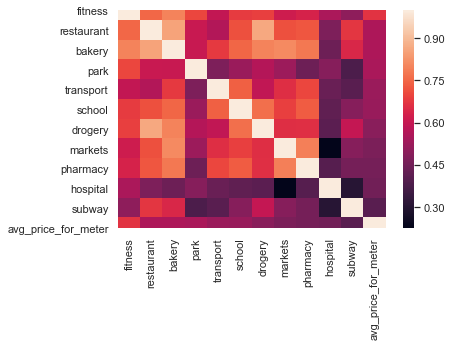

In [129]:
# Строим тепловую карту корреляций между объектами инфраструктуры и ценой для первой группы
corr_matrix = normalized_infr_prices_df[['fitness', 'restaurant', 'bakery', 'park', 'transport', 'school', 'drogery', 'markets', 'pharmacy', 'hospital', 'subway', 'avg_price_for_meter']].corr()
sns.set(font_scale=1)
sns.heatmap(corr_matrix)
corr_matrix

Вместо большого количества различных переменных инфраструктуры для дальнейшего анализа необходимо создать одну, которая с высокой степенью точности отражала бы общий уровень развития инфраструктуры для определенных жк. Сокращению размерности переменных инфраструктуры методом главных компонент посвящен отдельный раздел основного ноутбука с анализом данных - `main_data_analysis.ipynb`.